In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , RandomizedSearchCV , train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score ,roc_auc_score,average_precision_score,roc_curve,auc

In [2]:
df = pd.read_csv('Datasets/Bankrupt_in_1year.csv',na_values=['?'])
print(df.shape)


df['class'].value_counts()

(5910, 65)


0    5500
1     410
Name: class, dtype: int64

In [3]:
def data_cleaning(df):
    # Drop columns with missing rate > n
    n = 0.3
    missing  = df.isna().sum().sort_values(ascending = False ) / df.shape[0] 
    imputable_columns = missing[missing < n].keys()
    df = df.loc[:,imputable_columns]
    
    return df
    
def data_preprocessing(df , holdoutratio = 0.01):
    # Create Train fold  and hide Test fold
    test_sample_class = int(df.shape[0] * holdoutratio)

    df_dropNA = df.dropna() #Drop Nan
    Test_Operating  = df_dropNA[df_dropNA['class'] == 0].sample(n=test_sample_class)
    Test_Default    = df_dropNA[df_dropNA['class'] == 1].sample(n=int(test_sample_class/2))


    Test = pd.concat([Test_Default,Test_Operating] , 0) # Create the Hide pure Test Data

    Train = df.loc[~df.index.isin(Test.index), :] # Remove the index of Test and create the Train Block from original df

    Test.sample(frac=1) # Shuffle randomly the Test Block

    return Train , Test

def balanced_sample_traning(df,target = 'class'):
    target = 'class'

    min_sample_size = df[target].value_counts().min()
    positive = df[df[target] == 1].sample(n = min_sample_size)
    negative = df[df[target] == 0].sample(n = min_sample_size)


    Train = pd.concat([positive,negative] , 0).sample(frac=1)

    return Train
    
def Model_Pipeline(df,target = 'class',n_iter = 50,scoring = 'f1',n_splits = 3):
    # Split Predictor and Response
    X  = df.drop('class',1)
    y  = df['class']
    #Initialize Functions for Pipeline
    Clf = XGBClassifier(objective  = 'binary:logistic')
    Kf  = StratifiedKFold(n_splits=n_splits,shuffle=True)
    Imp = KNNImputer()
    #Grid of possible combinations of parameters
    param_dist = {
                  # Imputation params
                  "Imputation__n_neighbors" : [1,3,5],
                  # CLF params
                  "Clf__scale_pos_weight "   : [1, 3, 100] ,
                  "Clf__learning_rate"      : [0.01, 0.1, 0.3] ,
                  "Clf__max_depth"          : [ 3, 5, 6],
                  'Clf__n_estimators'       : [300,800,1000],
                  "Clf__gamma"              : [ 0.0, 0.1, 0.2],
                  "Clf__colsample_bytree"   : [ 0.5,0.7,1 ] 
    }
    # Pipeline Initialization
    pipeline = Pipeline([
                         ('Imputation',Imp),
                         ('Clf', Clf)
                        ])
    # Fit  model and validate model 
    GridS = RandomizedSearchCV(pipeline, 
                               param_distributions = param_dist,
                               cv = Kf,  
                               n_iter = n_iter,
                               scoring = scoring, 
                               error_score = 0, 
                               verbose = 0, 
                               n_jobs = -1)
    GridS.fit(X, y)
    return GridS , GridS.best_estimator_['Clf']
    

def Bankruptcy_Pipe(df):
    
    return 

In [4]:
import time
import warnings
warnings.filterwarnings('ignore')

t0 = time.time()
df = data_cleaning(df)
train , holdout = data_preprocessing(df)
train = balanced_sample_traning(train)
GridS , bestclf = Model_Pipeline(df = train)

t1 = time.time()

exec_time = t1 - t0

[10:09:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:09:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
print('Exec_time: Minutes',exec_time/60)
results = pd.DataFrame(GridS.cv_results_).sort_values('rank_test_score',ascending = True)[['mean_test_score','std_test_score']]
results.head()

Exec_time: Minutes 1.1943489948908488


,mean_test_score,std_test_score
11,0.847623,0.009287
27,0.844955,0.018646
21,0.842883,0.009864
39,0.842081,0.008341
35,0.841794,0.004010


In [6]:
predictors = train.drop('class',1).columns
feature_importances = pd.Series(data  = GridS.best_estimator_['Clf'].feature_importances_ , index = predictors)
feature_importances.sort_values(ascending = False)[:10]

Attr35    0.156006
Attr39    0.063748
Attr26    0.049483
Attr46    0.035538
Attr13    0.035455
Attr27    0.032512
Attr43    0.027319
Attr12    0.025552
Attr5     0.025079
Attr62    0.024590
dtype: float32

In [7]:
GridS.best_estimator_['Clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              scale_pos_weight =3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [8]:
# Unless the confidence of solid business is over 60, declare risk 
predictions  = (bestclf.predict_proba(holdout.drop('class',1).values)[:,1] >= 0.45).astype(int)

f1_score(holdout['class'] , predictions)

0.7042253521126761

In [9]:
train['class'].value_counts()

0    381
1    381
Name: class, dtype: int64

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        59
           1       0.60      0.86      0.70        29

    accuracy                           0.76        88
   macro avg       0.75      0.79      0.75        88
weighted avg       0.81      0.76      0.77        88



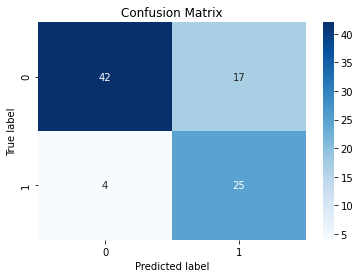

In [10]:
sns.heatmap(confusion_matrix( holdout['class'], predictions) , cmap  = 'Blues', annot = True )
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print(classification_report( holdout['class'], predictions))

# Unsupervised Bankruptcy Prediction with AutoEncoders

In [11]:
df = data_cleaning(df)


def data_preprocessing_autoencoder(df , holdoutratio = 0.01):
    # Create Train fold  and hide Test fold
    test_sample_class = int(df.shape[0] * holdoutratio)

    df_dropNA = df.dropna() #Drop Nan
    Test_Operating  = df_dropNA[df_dropNA['class'] == 0].sample(n=200,replace=False)
    Test_Default    = df_dropNA[df_dropNA['class'] == 1].sample(n=50)


    Test = pd.concat([Test_Default,Test_Operating] , 0) # Create the Hide pure Test Data

    Train = df.loc[~df.index.isin(Test.index), :] # Remove the index of Test and create the Train Block from original df

    Test.sample(frac=1) # Shuffle randomly the Test Block

    return Train , Test

train , holdout  = data_preprocessing(df)

train , validate = data_preprocessing_autoencoder(train)

train['class'].value_counts() ,validate['class'].value_counts()

(0    5241
 1     331
 Name: class, dtype: int64,
 0    200
 1     50
 Name: class, dtype: int64)

In [93]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import Normalizer, MinMaxScaler , StandardScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([
                     ('Imputation',KNNImputer()),
                     ('Standardize', StandardScaler()),
                     ('Scale', MinMaxScaler())
])


X_train    = train.drop('class',1)
X_validate = validate.drop('class',1)

# transform the training and validation data with these parameters
X_train_transformed = pipeline.fit_transform(X_train)
X_validate_transformed = pipeline.fit_transform(X_validate)


# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 2**5
EPOCHS = 200


def layer(n):
    layer= tf.keras.layers.Dense(n, activation='elu')
    return layer

latent = int(input_dim/4)
# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential(
    
    # deconstruct / encode
    [tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, ))]+ 
    [ layer(n)  for n in range(input_dim-1,latent,-1)] + 
    [layer(n)  for n in range(latent, input_dim+1,1)]
)

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["mse"])

# print an overview of our model
autoencoder.summary();

# Train 
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    verbose = False,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_447 (Dense)            (None, 63)                4032      
_________________________________________________________________
dense_448 (Dense)            (None, 62)                3968      
_________________________________________________________________
dense_449 (Dense)            (None, 61)                3843      
_________________________________________________________________
dense_450 (Dense)            (None, 60)                3720      
_________________________________________________________________
dense_451 (Dense)            (None, 59)                3599      
_________________________________________________________________
dense_452 (Dense)            (None, 58)                3480      
_________________________________________________________________
dense_453 (Dense)            (None, 57)               

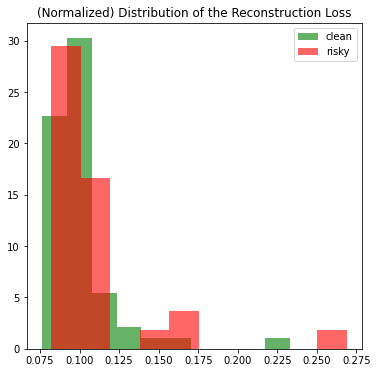

In [94]:
X_test    = holdout.drop('class',1)
y_test    = holdout['class']

X_test_transformed = pipeline.fit_transform(X_test)
reconstructions = autoencoder.predict(X_test_transformed)

mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

clean  = mse[y_test==0]
risky  = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=10, density=True, label="clean", alpha=.6, color="green")
ax.hist(risky, bins=10, density=True, label="risky", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

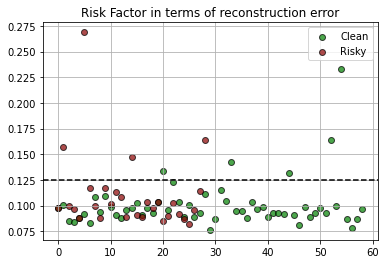

In [112]:
plt.grid(True)
plt.scatter(x = range(len(clean)) ,  y = clean , color = 'green', alpha = 0.7  ,edgecolors = 'k' , label  = 'Clean' )
plt.scatter(x = range(len(risky)) ,  y = risky , color = 'darkred', alpha = 0.7,edgecolors = 'k' , label  = 'Risky' )
plt.legend()
plt.title('Risk Factor in terms of reconstruction error')

risk_cutoff = np.percentile(mse,90)
plt.axhline(y=risk_cutoff, color='k', linestyle='--');

In [113]:
false_positive_rate = (clean[:] > risk_cutoff).astype(int).sum() / len(clean)
round(false_positive_rate,3)

0.085

In [114]:
false_negative_rate = (risky[:] < risk_cutoff).astype(int).sum() / len(risky)
round(false_negative_rate,3)

0.862

In [115]:
true_negative_rate = (clean[:] < risk_cutoff).astype(int).sum() / len(clean)
round(true_negative_rate,3)

0.915

In [116]:
true_positive_rate = (risky[:] > risk_cutoff).astype(int).sum() / len(risky)
round(true_positive_rate,3)

0.138

In [117]:
len(y_test) , len(clean) , len(risky)

(88, 59, 29)

In [118]:
true_positive    =   (risky[:] > risk_cutoff).astype(int).sum()
true_negative    =   (clean[:] < risk_cutoff).astype(int).sum()
false_positive   =   (clean[:] > risk_cutoff).astype(int).sum()
false_negative   =   (risky[:] < risk_cutoff).astype(int).sum()

precision  =  true_positive / ( true_positive + false_positive)
recall     =  true_positive / (true_positive + false_negative )

f1         =  2 * (precision*recall)/(precision+recall)

In [119]:
recall

0.13793103448275862

In [120]:
true_positive_rate*29

4.0